# Computer Vision in MXNet

Welcome to the tutorial! This tutorial will guide you through an example of Computer Vision on the MNIST dataset using MXNet. In the tutorial, we will cover: 
- What is an artificial neuron? 
- the MNIST data set
- fully connected, 
- constructing a feed-forward model
- debugging 

First let's import the modules and setup logging:

In [5]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## MNIST Data
[MNIST](http://yann.lecun.com/exdb/mnist/) is a data set of handwritten digits with corresponding labels. You can think of each image as a 28x28 matrix, each of which is comprised by an integer between 0 and 255 corresponding with a greyscale value: 

<img src="https://thatindiandude.github.io/images/pixelated_digit.png" style="height: 250px; margin: 0 auto;">
<img src="https://thatindiandude.github.io/images/pixel2mat.jpeg" style="height: 250px;">

<br><br>

<ul style="font-size: 10px;">
    <li style="list-style-type: none;"><i>Left: https://www.simplicity.be/article/recognizing-handwritten-digits/</i></li>
    <li style="list-style-type: none;"><i>Right: http://apapiu.github.io/figs/MINST/Users/alexpapiu/GitHub/apapiu.github.iounnamed-chunk-3-1.png</i></li>
</ul>

The end result is predicting a  <b>label</b>. In this case, this is a guess as to what digit is found in the input image. 

## Artificial Neuron 

A neural network consists of four parts:
- an input $(I_j)$
- weight parameter $(w_{ij})$
- activation function $(f)$
- threshold value ($T$)

<ul style="list-style-type:none;"> 
    <li><b>Figure 1:</b> The $i^{th}$ layer in a neural net with $N$ inputs:</li>
    <li><img src="https://thatindiandude.github.io/images/ann.gif"></li>
    <li><i>CREDIT: http://ulcar.uml.edu/~iag/CS/A-Neuron.gif</i></li>
</ul>

### Process

1. A value $I_j$ is one of $N$ inputs to a neuron. Each such input has its own weight, $w_{ij}$ ($i$ = layer,  $j$ = input id).


2. When the input is fed into the neuron, we  compute the following <b>inner product</b>:
$$x = \sum_{j=1}^{N}W_jI_j$$


3. A bias $b$ may be added to the inner product,and this sum will ultimately passed through the activation function $f$: $$ f(\sum_{j=1}^{N}W_jI_j + b) = f(x + b)$$


4. Then, we may apply a threshold $T$ so that an output $S$ is calculated: $$ S = f(x + b) > T $$ 


5. The output $S$ is then either <b>sent to another layer as input</b>, or is the final output of neural network and <b>makes a prediction</b>.

## Model construction 
We will define the following model, layer by layer. 

<img src="https://thatindiandude.github.io/images/full_model.png">

An important note to remember when using MXNet is variable naming: 

- All input arrays have a name. This includes inputs (data & label) and model parameters (weight, bias, etc).
- Arrays can be renamed by creating named variable. Otherwise, a default name is given as 'SymbolName_ArrayName'. For example, FullyConnected symbol fc1's weight array is named as 'fc1_weight'.
- Although you can also rename weight arrays with variables, weight array's name should always end with '_weight' and bias array '_bias'. MXNet relies on the suffixes of array names to correctly initialize & update them.

First, we define the input layer: 

In [8]:
# Variables are place holders for input arrays. We give each variable a unique name.
data = mx.symbol.Variable('data')

Then, the neural network needs to deconstruct the image. We will do this using a fully connected layer. 

### Fully Connected Layer
By their namesake, neurons in a fully connected layer are individually connected to all other neurons in the next layer:

<img src="https://thatindiandude.github.io/images/fc_layer.jpeg">

As opposed to convolutional layers, in which each neurons was only connected to a few local neurons in a past layer, fully connected layers don't make the assumptions of spatial locality in its features. However, we do so at the cost of more memory, as each connection has its own weight, and runtime, as inner products are much larger. 

We can both have more units in an individual hidden layer and have more hidden layers. We define the number of neurons in the hidden layer using `num_hidden` parameter, and define its input using the `data` parameter:

In [14]:
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)

### Activation

Activation functions can be applied to the sum of the inner product and bias to add non-linearity. In this case, we will use the rectified linear unit (or "ReLU" for short). Formally, the ReLU activation is defined as 

$$f(x) = \max{(0,x)}$$

and looks like this: 
<img src="https://thatindiandude.github.io/images/relu2.jpeg">
<i style="text-align: center;">CREDIT: http://cs231n.github.io/neural-networks-1/</i>

We like to use ReLU activations for a number of reasons: 
- differentiable, allows us to compute gradient
- resulting 0s create sparse representations
- reduces likelihood of vanishing gradient 

Finally, evidence from [Krizhevksy et al.](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) shows a 6x improvement in convergence by using a ReLU activation compared to a tanh activation.  
<img src="https://thatindiandude.github.io/images/relu.jpeg">

In [17]:
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

We will fill out the rest of the model with the code below, using layers we've previously covered. 

In [22]:
fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)

### Loss Layer

Finally, we will use a softmax layer to make our prediction, namely a digit between 0 and 9. The softmax normalizes a vector into a probability distribution, namely: 

$$softmax(x) = \frac{\exp{(x)}}{\sum_{j}{\exp{(x_j)}}}$$

In [23]:
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

To confirm our network's layout, we can visualize the network we just defined with MXNet's visualization module:

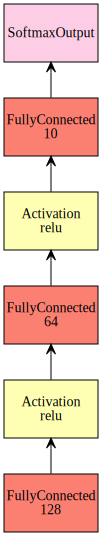

In [24]:
mx.viz.plot_network(mlp)

## Data Loading

We fetch and load the MNIST dataset and partition it into two sets: 60000 examples for training and 10000 examples for testing. We also visualize a few examples to get an idea of what the dataset looks like.

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]

Now we can create data iterators from our MNIST data. A data iterator returns a batch of data examples each time for the network to process. MXNet provide a suite of basic DataIters for parsing different data format. Here we use NDArrayIter, which wraps around a numpy array and each time slice a chunk from it along the first dimension.

In [ ]:
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

## Training

With the network and data source defined, we can finally start to train our model. We do this with MXNet's convenience wrapper for feed forward neural networks (it can also be made to handle RNNs with explicit unrolling). 

In [ ]:
model = mx.model.FeedForward(
    ctx = mx.gpu(0),      # Run on GPU 0
    symbol = mlp,         # Use the network we just defined
    num_epoch = 10,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001)         # Weight decay for regularization
model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter,  # Testing data set. MXNet computes scores on test set every epoch
    batch_end_callback = mx.callback.Speedometer(batch_size, 200))  # Logging module to print out progress

## Evaluation

After the model is trained, we can evaluate it on a held out test set.
First, lets classity a sample image:

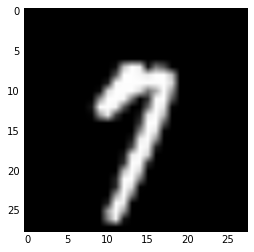

Result: 7


In [9]:
plt.imshow((X_test[0].reshape((28,28))*255).astype(np.uint8), cmap='Greys_r')
plt.show()
print 'Result:', model.predict(X_test[0:1])[0].argmax()

We can also evaluate the model's accuracy on the entire test set:

In [10]:
print 'Accuracy:', model.score(test_iter)*100, '%'

Accuracy: 97.33 %


Now, try if your model recognizes your own hand writing.

Write a digit from 0 to 9 in the box below. Try to put your digit in the middle of the box.

In [ ]:
# run hand drawing test
from IPython.display import HTML

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1, 784))/255.0
    return model.predict(img)[0].argmax()

html = """<style type="text/css">canvas { border: 1px solid black; }</style><div id="board"><canvas id="myCanvas" width="100px" height="100px">Sorry, your browser doesn't support canvas technology.</canvas><p><button id="classify" onclick="classify()">Classify</button><button id="clear" onclick="myClear()">Clear</button>Result: <input type="text" id="result_output" size="5" value=""></p></div>"""
script = """<script type="text/JavaScript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2"></script><script type="text/javascript">function init() {var myCanvas = document.getElementById("myCanvas");var curColor = $('#selectColor option:selected').val();if(myCanvas){var isDown = false;var ctx = myCanvas.getContext("2d");var canvasX, canvasY;ctx.lineWidth = 8;$(myCanvas).mousedown(function(e){isDown = true;ctx.beginPath();var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.moveTo(canvasX, canvasY);}).mousemove(function(e){if(isDown != false) {var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.lineTo(canvasX, canvasY);ctx.strokeStyle = curColor;ctx.stroke();}}).mouseup(function(e){isDown = false;ctx.closePath();});}$('#selectColor').change(function () {curColor = $('#selectColor option:selected').val();});}init();function handle_output(out) {document.getElementById("result_output").value = out.content.data["text/plain"];}function classify() {var kernel = IPython.notebook.kernel;var myCanvas = document.getElementById("myCanvas");data = myCanvas.toDataURL('image/png');document.getElementById("result_output").value = "";kernel.execute("classify('" + data +"')",  { 'iopub' : {'output' : handle_output}}, {silent:false});}function myClear() {var myCanvas = document.getElementById("myCanvas");myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);}</script>"""
HTML(html+script)

## Further Readings

- More state-of-the-art cnn models are available at [mxnet/example/image-classification](https://github.com/dmlc/mxnet/tree/master/example/image-classification)